<a href="https://colab.research.google.com/github/coopersully/cosc470s24/blob/main/solutions/frog_generator/GAN_Frogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [16]:
def define_discriminator(input_shape=(32, 32, 3)):
    """
    Define the discriminator model structure for the DCGAN.
    
    Parameters:
    - input_shape: tuple, shape of the input images. Default is (32, 32, 3) for 32x32 RGB images.
    
    Returns:
    - Compiled Keras model of the discriminator.
    """
    model = Sequential()

    # Initial convolutional layer with input shape specification
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))

    # First downsample: reduces image dimensions by half, increases depth
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Second downsample
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Third downsample
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Flatten the output of the last convolutional layer
    model.add(Flatten())

    # Dropout for regularization (helps prevent overfitting)
    model.add(Dropout(0.4))

    # Output layer: binary classification (real or fake)
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the model with Adam optimizer and binary crossentropy loss
    # Adjusted learning rate and beta_1 for stable training
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [17]:
def define_generator(latent_dim):
    """
    Define the generator model structure for the DCGAN.

    Parameters:
    - latent_dim: int, size of the latent space (noise vector input).
    
    Returns:
    - Uncompiled Keras model of the generator.
    """
    model = Sequential()

    # Foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    # Upsample to 8x8
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 16x16
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 32x32
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer with tanh activation for generating images
    model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    
    return model

In [18]:
def define_gan(generator_model, discriminator_model):
    """
    Define the combined GAN model for training the generator.

    Parameters:
    - generator_model: Model, the generator component of the GAN.
    - discriminator_model: Model, the discriminator component of the GAN, set to non-trainable.
    
    Returns:
    - Compiled Keras model of the combined GAN, ready for training the generator.
    """
    # Set discriminator weights to non-trainable (only when part of the combined model)
    discriminator_model.trainable = False

    # Initialize the combined model
    model = Sequential()

    # Add generator
    model.add(generator_model)

    # Add discriminator
    model.add(discriminator_model)

    # Compile the combined model
    # The optimizer and loss function are set up for training the generator
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return model

In [19]:
def load_real_samples():
    """
    Load and prepare CIFAR-10 frog images.

    Returns:
    - X: numpy array, CIFAR-10 frog images normalized to [-1, 1].
    """
    # Load CIFAR-10 dataset
    (trainX, trainy), (_, _) = load_data()
    
    # Filter for frogs, which are class 6
    indices = np.where(trainy == 6)
    trainX = trainX[indices[0]]
    
    # Convert image data from unsigned integers to floats
    X = trainX.astype('float32')
    
    # Normalize the images from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    
    return X

# Load the real samples for use
a = load_real_samples()

In [20]:
def generate_real_samples(dataset, n_samples):
    """
    Select a random subset of real samples from a dataset.

    Parameters:
    - dataset: numpy array, the collection of images to select real samples from.
    - n_samples: int, the number of real samples to select.
    
    Returns:
    - X: numpy array, the selected images.
    - y: numpy array, an array of labels marking the selected images as real.
    """
    # Choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    
    # Retrieve selected images
    X = dataset[ix]
    
    # Generate 'real' class labels (1) for the selected samples
    y = ones((n_samples, 1))
    
    return X, y

In [21]:
def generate_latent_points(latent_dim, n_samples):
    """
    Generate points in the latent space as input for the generator.

    Parameters:
    - latent_dim: int, the dimensionality of the latent space.
    - n_samples: int, the number of samples to generate in the latent space.
    
    Returns:
    - x_input: numpy array, batch of latent points reshaped for the generator network.
    """
    # Generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [22]:
def generate_fake_samples(generator_model, latent_dim, n_samples):
    """
    Use the generator to generate 'n' fake examples, along with their class labels.
    
    Parameters:
    - generator_model: Model, the generator component of the GAN.
    - latent_dim: int, the dimensionality of the latent space.
    - n_samples: int, the number of fake samples to generate.
    
    Returns:
    - X: numpy array, the generated fake images.
    - y: numpy array, an array of labels marking the images as fake.
    """
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # Use the generator model to predict (generate) outputs
    X = generator_model.predict(x_input)
    
    # Create 'fake' class labels (0) for the generated images
    y = zeros((n_samples, 1))
    
    return X, y

In [23]:
def save_plot(examples, epoch, n=7):
    """
    Create and save a plot of generated images.

    Parameters:
    - examples: numpy array, the generated images to plot.
    - epoch: int, the current epoch number, used to name the saved file.
    - n: int, the number of images to display along each dimension of the grid. Default is 7.
    """
    # Scale from [-1,1] to [0,1] for plotting
    examples = (examples + 1) / 2.0
    
    # Plot images
    for i in range(n * n):
        # Define subplot
        pyplot.subplot(n, n, 1 + i)
        # Turn off axis
        pyplot.axis('off')
        # Plot raw pixel data
        pyplot.imshow(examples[i])
    
    # Save plot to file
    filename = f'generated_plot_e{epoch+1:03d}.png'
    pyplot.savefig(filename)
    pyplot.close()


In [24]:
def summarize_performance(epoch, generator_model, discriminator_model, dataset, latent_dim, n_samples=150):
    """
    Evaluate the discriminator, plot generated images, and save the generator model.

    Parameters:
    - epoch: int, the current training epoch.
    - generator_model: Model, the generator component of the GAN.
    - discriminator_model: Model, the discriminator component of the GAN.
    - dataset: numpy array, the dataset of real images.
    - latent_dim: int, the dimensionality of the latent space.
    - n_samples: int, the number of samples to generate for evaluation. Default is 150.
    """
    # Prepare real samples and evaluate discriminator on real examples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)

    # Prepare fake examples and evaluate discriminator on fake examples
    x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, n_samples)
    _, acc_fake = discriminator_model.evaluate(x_fake, y_fake, verbose=0)

    # Summarize discriminator performance
    print(f'>Accuracy real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%')

    # Save plot of fake images
    save_plot(x_fake, epoch)

    # Save the generator model
    filename = f'generator_model_{epoch+1:03d}.h5'
    generator_model.save(filename)

In [25]:
def summarize_performance(epoch, generator_model, discriminator_model, dataset, latent_dim, n_samples=150):
    """
    Evaluate the discriminator, plot generated images, and save the generator model.

    Parameters:
    - epoch: int, the current training epoch.
    - generator_model: Model, the generator component of the GAN.
    - discriminator_model: Model, the discriminator component of the GAN.
    - dataset: numpy array, the dataset of real images.
    - latent_dim: int, the dimensionality of the latent space.
    - n_samples: int, the number of samples to generate for evaluation. Default is 150.
    """
    # Prepare real samples and evaluate discriminator on real examples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = discriminator_model.evaluate(X_real, y_real, verbose=0)

    # Prepare fake examples and evaluate discriminator on fake examples
    x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, n_samples)
    _, acc_fake = discriminator_model.evaluate(x_fake, y_fake, verbose=0)

    # Summarize discriminator performance
    print(f'>Accuracy real: {acc_real*100:.0f}%, fake: {acc_fake*100:.0f}%')

    # Save plot of fake images
    save_plot(x_fake, epoch)

    # Save the generator model
    filename = f'generator_model_{epoch+1:03d}.h5'
    generator_model.save(filename)

def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    """
    Train the generator and discriminator of the GAN.

    Parameters:
    - generator_model: Model, the generator component of the GAN.
    - discriminator_model: Model, the discriminator component of the GAN.
    - gan_model: Model, the combined GAN model for updating the generator.
    - dataset: numpy array, the dataset of real images.
    - latent_dim: int, the dimensionality of the latent space.
    - n_epochs: int, the number of epochs to train for. Default is 200.
    - n_batch: int, the size of the batch. Default is 128.
    """
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Manually enumerate epochs
    for epoch in range(n_epochs):
        # Enumerate batches over the training set
        for batch in range(bat_per_epo):
            # Get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Update discriminator model weights
            d_loss_real = discriminator_model.train_on_batch(X_real, y_real)[0]
            
            # Generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
            # Update discriminator model weights
            d_loss_fake = discriminator_model.train_on_batch(X_fake, y_fake)[0]

            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # Update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Summarize loss on this batch
            print(f'>{epoch+1}, {batch+1}/{bat_per_epo}, d_loss_real={d_loss_real:.3f}, d_loss_fake={d_loss_fake:.3f}, g_loss={g_loss:.3f}')

        # Evaluate the model performance, sometimes
        if (epoch + 1) % 10 == 0:
            summarize_performance(epoch, generator_model, discriminator_model, dataset, latent_dim)

In [26]:
latent_dim = 100

# Create models
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

# Load CIFAR-10 dataset 
dataset = load_real_samples()

# Train model(s)
train(g_model, d_model, gan_model, dataset, latent_dim, 50)

2/2 [==============================] - 1s 202ms/step
>1, 1/39, d1=0.692, d2=0.711 g=0.690
2/2 [==============================] - 0s 209ms/step
>1, 2/39, d1=0.456, d2=0.804 g=0.659
2/2 [==============================] - 0s 211ms/step
>1, 3/39, d1=0.135, d2=1.480 g=0.697
2/2 [==============================] - 0s 198ms/step
>1, 4/39, d1=0.138, d2=0.950 g=0.943
2/2 [==============================] - 1s 306ms/step
>1, 5/39, d1=0.428, d2=0.648 g=0.801
2/2 [==============================] - 0s 196ms/step
>1, 6/39, d1=0.319, d2=0.862 g=0.741
2/2 [==============================] - 0s 198ms/step
>1, 7/39, d1=0.142, d2=0.678 g=0.717
2/2 [==============================] - 1s 306ms/step
>1, 8/39, d1=0.171, d2=0.698 g=0.715
2/2 [==============================] - 0s 191ms/step
>1, 9/39, d1=0.088, d2=0.719 g=0.717
2/2 [==============================] - 0s 199ms/step
>1, 10/39, d1=0.025, d2=0.806 g=0.777
2/2 [==============================] - 1s 308ms/step
>1, 11/39, d1=0.057, d2=0.613 g=0.930
2/2 [===

2/2 [==============================] - 0s 196ms/step
>11, 1/39, d1=0.404, d2=0.813 g=2.632
2/2 [==============================] - 0s 188ms/step
>11, 2/39, d1=0.456, d2=0.211 g=2.307
2/2 [==============================] - 1s 315ms/step
>11, 3/39, d1=0.281, d2=2.558 g=3.400
2/2 [==============================] - 0s 195ms/step
>11, 4/39, d1=2.340, d2=0.353 g=1.188
2/2 [==============================] - 0s 195ms/step
>11, 5/39, d1=0.757, d2=0.590 g=1.037
2/2 [==============================] - 1s 292ms/step
>11, 6/39, d1=0.689, d2=0.557 g=1.085
2/2 [==============================] - 0s 212ms/step
>11, 7/39, d1=0.623, d2=0.543 g=1.043
2/2 [==============================] - 0s 211ms/step
>11, 8/39, d1=0.608, d2=0.640 g=0.950
2/2 [==============================] - 1s 222ms/step
>11, 9/39, d1=0.518, d2=0.897 g=0.951
2/2 [==============================] - 0s 191ms/step
>11, 10/39, d1=0.533, d2=0.765 g=0.931
2/2 [==============================] - 0s 199ms/step
>11, 11/39, d1=0.561, d2=0.714 g=1.0

2/2 [==============================] - 0s 191ms/step
>21, 1/39, d1=0.549, d2=1.009 g=2.031
2/2 [==============================] - 0s 204ms/step
>21, 2/39, d1=0.782, d2=0.296 g=1.704
2/2 [==============================] - 0s 196ms/step
>21, 3/39, d1=0.736, d2=0.540 g=1.241
2/2 [==============================] - 0s 191ms/step
>21, 4/39, d1=0.678, d2=0.905 g=1.404
2/2 [==============================] - 0s 203ms/step
>21, 5/39, d1=0.794, d2=0.521 g=1.418
2/2 [==============================] - 0s 196ms/step
>21, 6/39, d1=0.862, d2=0.739 g=1.084
2/2 [==============================] - 0s 222ms/step
>21, 7/39, d1=0.730, d2=0.752 g=1.000
2/2 [==============================] - 0s 194ms/step
>21, 8/39, d1=0.753, d2=0.712 g=1.045
2/2 [==============================] - 0s 200ms/step
>21, 9/39, d1=0.714, d2=0.534 g=1.243
2/2 [==============================] - 0s 193ms/step
>21, 10/39, d1=0.545, d2=0.444 g=1.514
2/2 [==============================] - 0s 194ms/step
>21, 11/39, d1=0.459, d2=0.625 g=1.4

2/2 [==============================] - 0s 195ms/step
>31, 1/39, d1=0.659, d2=0.642 g=1.108
2/2 [==============================] - 1s 312ms/step
>31, 2/39, d1=0.593, d2=0.614 g=1.046
2/2 [==============================] - 0s 189ms/step
>31, 3/39, d1=0.680, d2=0.760 g=0.956
2/2 [==============================] - 0s 194ms/step
>31, 4/39, d1=0.683, d2=0.639 g=0.975
2/2 [==============================] - 0s 192ms/step
>31, 5/39, d1=0.719, d2=0.655 g=1.040
2/2 [==============================] - 0s 189ms/step
>31, 6/39, d1=0.708, d2=0.640 g=1.056
2/2 [==============================] - 0s 194ms/step
>31, 7/39, d1=0.689, d2=0.627 g=1.108
2/2 [==============================] - 0s 196ms/step
>31, 8/39, d1=0.603, d2=0.595 g=1.082
2/2 [==============================] - 0s 188ms/step
>31, 9/39, d1=0.669, d2=0.718 g=0.989
2/2 [==============================] - 0s 192ms/step
>31, 10/39, d1=0.687, d2=0.716 g=0.951
2/2 [==============================] - 0s 192ms/step
>31, 11/39, d1=0.641, d2=0.730 g=0.9

2/2 [==============================] - 0s 212ms/step
>41, 1/39, d1=0.520, d2=0.900 g=1.043
2/2 [==============================] - 1s 311ms/step
>41, 2/39, d1=0.717, d2=0.635 g=1.140
2/2 [==============================] - 0s 189ms/step
>41, 3/39, d1=0.719, d2=0.566 g=1.059
2/2 [==============================] - 0s 195ms/step
>41, 4/39, d1=0.696, d2=0.700 g=1.030
2/2 [==============================] - 0s 215ms/step
>41, 5/39, d1=0.751, d2=0.689 g=1.048
2/2 [==============================] - 0s 195ms/step
>41, 6/39, d1=0.666, d2=0.626 g=1.008
2/2 [==============================] - 0s 198ms/step
>41, 7/39, d1=0.677, d2=0.712 g=1.110
2/2 [==============================] - 0s 196ms/step
>41, 8/39, d1=0.722, d2=0.634 g=1.065
2/2 [==============================] - 0s 196ms/step
>41, 9/39, d1=0.754, d2=0.574 g=1.090
2/2 [==============================] - 0s 197ms/step
>41, 10/39, d1=0.689, d2=0.649 g=1.071
2/2 [==============================] - 0s 195ms/step
>41, 11/39, d1=0.653, d2=0.683 g=1.0

In [27]:
def create_plot(examples, n):
    """
    Plot a grid of the generated images.

    Parameters:
    - examples: numpy array, the generated images to be plotted.
    - n: int, the dimension of the grid to display (e.g., n=3 for a 3x3 grid).
    """
    # Plot images in a grid of 'n x n'
    for i in range(n * n):
        # Define subplot
        pyplot.subplot(n, n, 1 + i)
        
        # Turn off axis to focus on the images
        pyplot.axis('off')
        
        # Plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    
    # Display the plot
    pyplot.show()

4/4 [==============================] - 1s 148ms/step


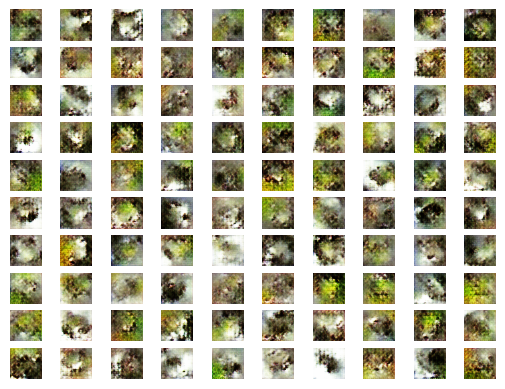

In [28]:
# Generate images
latent_points = generate_latent_points(100, 100)
X = g_model.predict(latent_points)
X = (X + 1)/ 2.0

# Plot a 10x10 grid of the generated images
create_plot(X, 10)